In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as kpss
from scipy import stats
import warnings
import itertools
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('spending_by_day.csv')
#df['data'] = df.data.apply(lambda x: x[0:10].encode().decode('utf-8'))
df['data'] = df.data.apply(lambda x: x[0:10])
df['data'] = pd.to_datetime(df.data, errors='coerce')
df.set_index('data', inplace=True)
df.head()

,sum
data,
2018-01-01,1.897892e+06
2018-01-02,5.438664e+06
2018-01-03,5.628547e+06
2018-01-04,6.056366e+06
2018-01-05,6.064084e+06


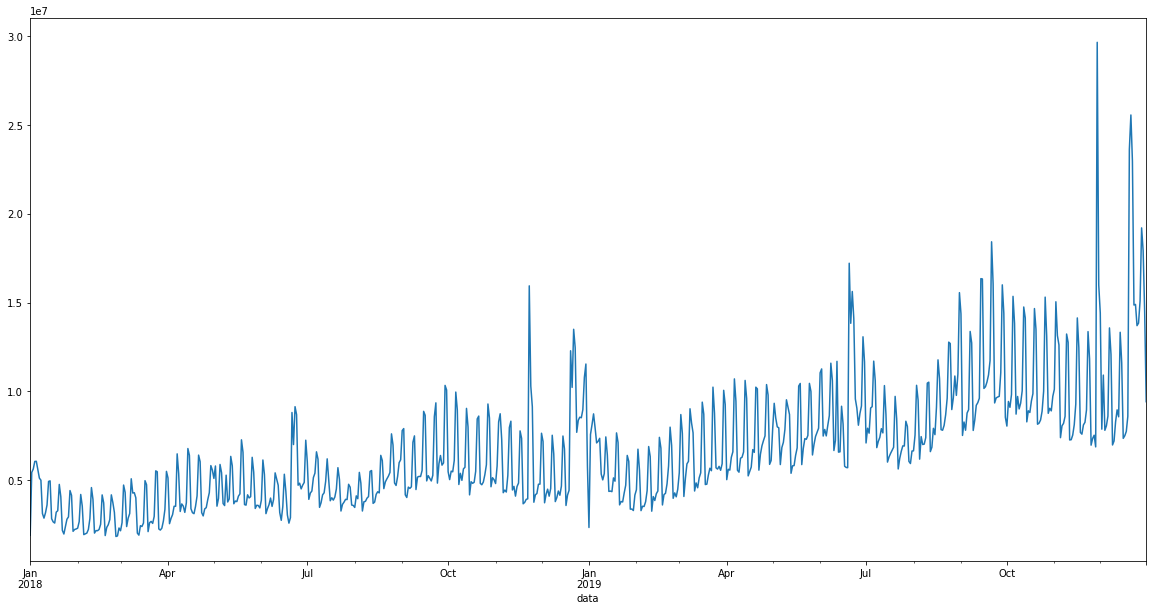

In [3]:
ts = df['sum']

plt.figure(figsize=(20, 10))
ts.plot()
plt.show()

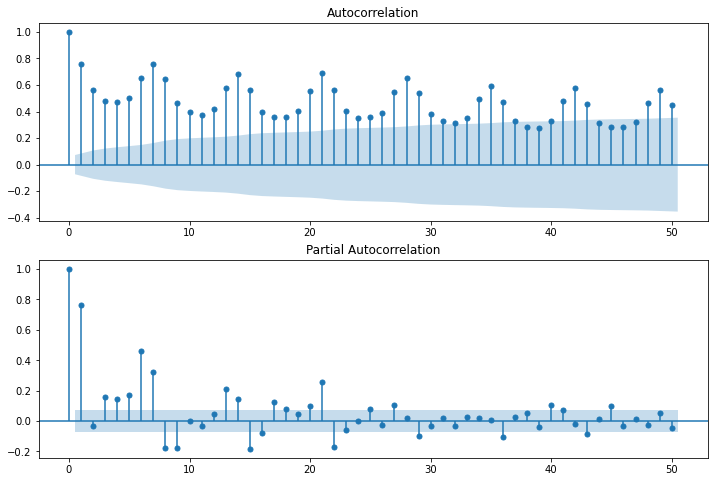

In [4]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=50, ax=ax2)

Проведем предобработку данных. Проверим нет ли в данных пропусков.

In [5]:
ts.reset_index().isnull().any()

data    False
sum     False
dtype: bool

Пропусков Nan в данных не наблюдает, сгладим временной ряд с помощью преобразования Бокса-Кокса

In [6]:
from scipy.stats import boxcox

In [7]:
data = ts
data
result, lmbda = boxcox(data)
ts

data
2018-01-01    1.897892e+06
2018-01-02    5.438664e+06
2018-01-03    5.628547e+06
2018-01-04    6.056366e+06
2018-01-05    6.064084e+06
                  ...     
2019-12-27    1.509453e+07
2019-12-28    1.920698e+07
2019-12-29    1.791994e+07
2019-12-30    1.447355e+07
2019-12-31    9.420428e+06
Name: sum, Length: 730, dtype: float64

In [8]:
result = pd.Series(result, index=ts.index)
ts = result
ts[:'2019-09-01']

data
2018-01-01    14.100958
2018-01-02    15.100605
2018-01-03    15.133130
2018-01-04    15.202547
2018-01-05    15.203753
                ...    
2019-08-28    15.755804
2019-08-29    15.655774
2019-08-30    15.765948
2019-08-31    16.095153
2019-09-01    16.020032
Length: 609, dtype: float64

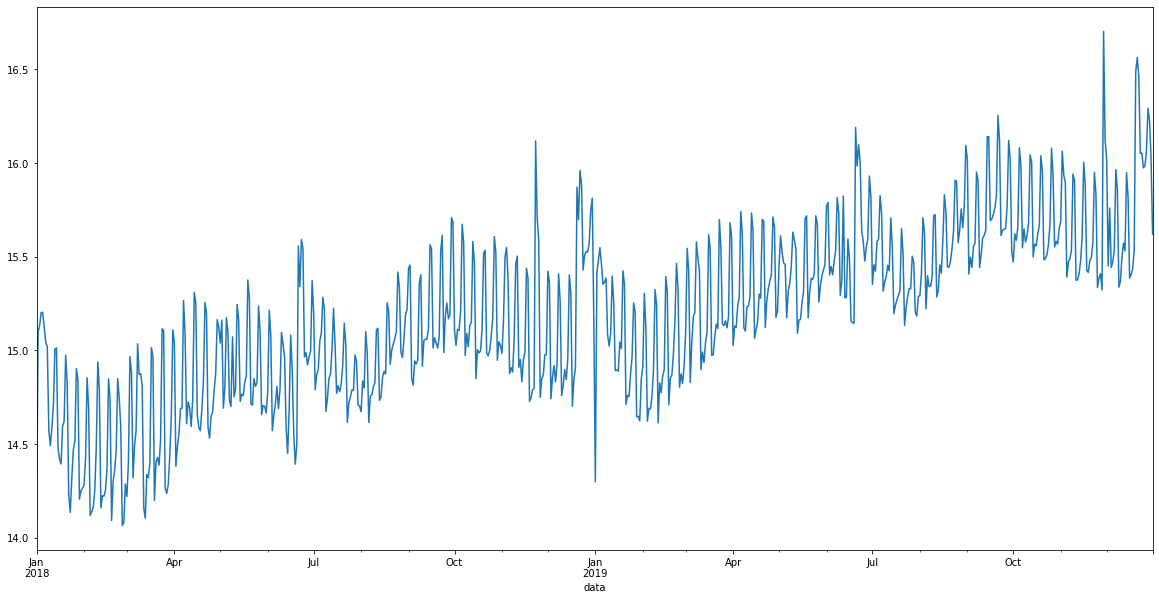

In [9]:
plt.figure(figsize=(20, 10))
ts.plot()
plt.show()

Итак, из графика можно заметить ярко выраженный тренд и возможно сезонность. Поэтому перед построением модели нам необходимо избавиться от них.

Определим d и D. Будем дифференцировать ряд до тех пор, пока он не станет стационарным. Проверку стационарности будем осуществлять с помощью статистического теста.

In [10]:
ts1diff = ts.diff(periods=1).dropna()
ts1diff

data
2018-01-02    0.999647
2018-01-03    0.032524
2018-01-04    0.069417
2018-01-05    0.001206
2018-01-06   -0.079455
                ...   
2019-12-27    0.081552
2019-12-28    0.227464
2019-12-29   -0.065461
2019-12-30   -0.201682
2019-12-31   -0.405950
Length: 729, dtype: float64

Проверим получившийся ряд на стационарность:

In [11]:
test = sm.tsa.adfuller(ts1diff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.5775817758381105
p-value:  2.7355975598265085e-11
Critical values:  {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
единичных корней нет, ряд стационарен


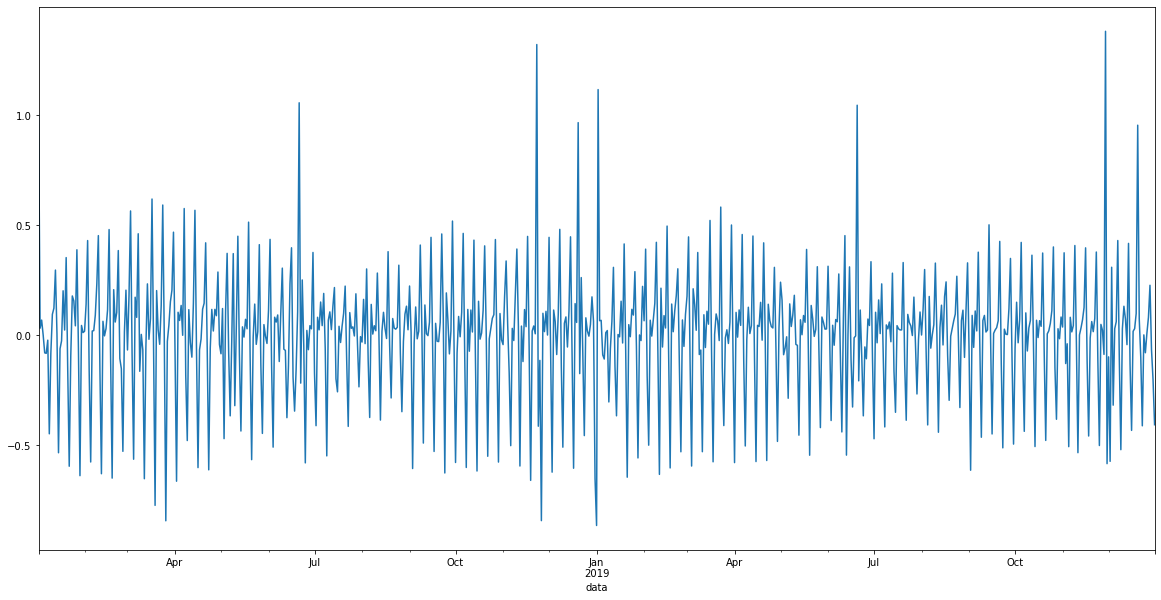

In [12]:
ts1diff.plot(figsize=(20,10))
plt.show()

Мы избавились от тренда. таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка

In [13]:
d = 1

Осталось избавиться от сезонности.
Для этого нужно взять сезонную разность, от нашего получившегося ряда. 

In [14]:
ts1diff_season = ts1diff.diff(365).dropna()

In [15]:
test = sm.tsa.adfuller(ts1diff_season)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -9.145791139405883
p-value:  2.7703907455912768e-15
Critical values:  {'1%': -3.4491725955218655, '5%': -2.8698334971428574, '10%': -2.5711883591836733}
единичных корней нет, ряд стационарен


In [16]:
ts1diff_season1diff = ts1diff_season.diff().dropna()

test = sm.tsa.adfuller(ts1diff_season1diff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')
#plt.show()

adf:  -12.407427892581541
p-value:  4.4202967944206085e-23
Critical values:  {'1%': -3.4493918438232525, '5%': -2.8699298018856574, '10%': -2.5712397066390458}
единичных корней нет, ряд стационарен


In [17]:
D = 1

Начнем строить модель класса ARIMA

Для обучения возьмем период [:'2019-09-01']. 

In [18]:
src_data_model = ts[:'2019-09-01']
src_data_model
model = sm.tsa.ARIMA(src_data_model, order=(1,1,4)).fit(full_output=False, disp=0)

In [19]:
pred = model.predict('2019-09-01','2020-02-01', typ='levels')

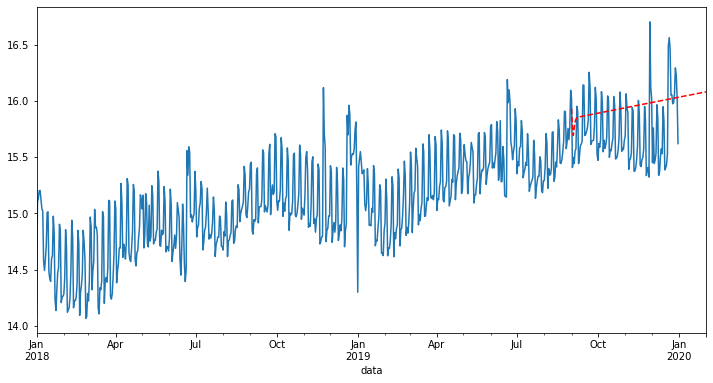

In [20]:
ts.plot(figsize=(12,6))
pred.plot(style='r--')
plt.show()

Простая модель ARIMA, аналогичная модели с лекции. Приведена для сравнения.

In [21]:
mod = sm.tsa.statespace.SARIMAX(ts[:'2019-09-01'],
                                order=(1, 1, 4),
                                seasonal_order=(0, 1, 4, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
res = mod.filter(results.params)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5132      0.131      3.918      0.000       0.256       0.770
ma.L1         -0.9498      0.133     -7.167      0.000      -1.210      -0.690
ma.L2         -0.2514      0.082     -3.062      0.002      -0.412      -0.090
ma.L3          0.0736      0.086      0.858      0.391      -0.095       0.242
ma.L4          0.2483      0.051      4.827      0.000       0.147       0.349
ma.S.L12      -1.2816      0.047    -27.066      0.000      -1.374      -1.189
ma.S.L24       0.1623      0.082      1.984      0.047       0.002       0.323
ma.S.L36       0.1333      0.096      1.389      0.165      -0.055       0.321
ma.S.L48       0.0316      0.056      0.561      0.575      -0.079       0.142
sigma2         0.0484      0.002     20.622      0.000       0.044       0.053


Необходимо проверить остаточные графики, чтобы проверить достоверность подгонки модели. Хороший метод прогнозирования дает остатки со следующими свойствами:

1. Остатки некоррелированы. Если между остатками есть корреляции, значит, в остатках остается информация, которую следует использовать при вычислении прогнозов.

2. Остатки имеют нулевое среднее. Если остатки имеют среднее значение, отличное от нуля, то прогнозы смещены.

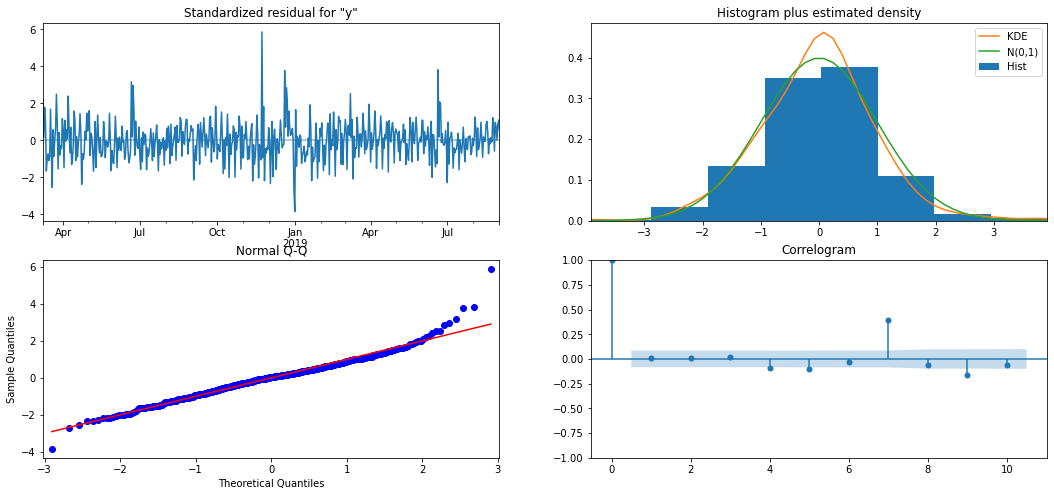

In [22]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Как видно из изображения выше, остатки имеют нулевое среднее значение и график остаток похож на шум.

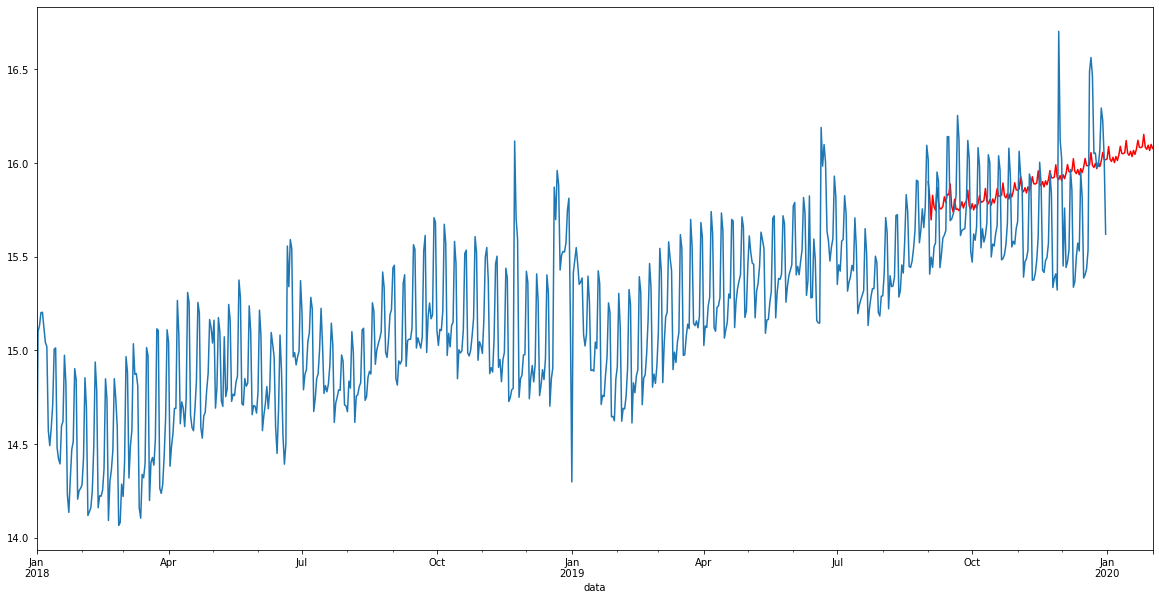

In [23]:
plt.figure(figsize=(20, 10))
pred = results.get_prediction(start=pd.to_datetime('2019-09-01'),end='2020-02-01', dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.plot(color='r')
ts.plot()
y_forecasted = pred.predicted_mean

Модель хорошо предсказывает спады и подъемы, но размах этих подъемов недостаточный. Возможно, что дело в том, что для обучения было взято, что количество периодов в сезоне равняется 12 - такой параметр берут для временных рядов ежемесячной динамики, 4 - для квартальных данных. 52 - для недельных. Исходные данные - ежедневные.

In [34]:
mod = sm.tsa.statespace.SARIMAX(ts[:'2019-09-01'].resample('W').mean(),
                                order=(1, 1, 4),
                                seasonal_order=(0, 1, 4, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
res = mod.filter(results.params)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3443         -0        inf      0.000      -0.344      -0.344
ma.L1         -0.2810         -0        inf      0.000      -0.281      -0.281
ma.L2         -0.2843         -0        inf      0.000      -0.284      -0.284
ma.L3         -0.3896         -0        inf      0.000      -0.390      -0.390
ma.L4         -0.3516         -0        inf      0.000      -0.352      -0.352
ma.S.L52            0         -0        nan        nan           0           0
ma.S.L104           0         -0        nan        nan           0           0
ma.S.L156           0         -0        nan        nan           0           0
ma.S.L208           0         -0        nan        nan           0           0
sigma2         0.0076         -0       -inf      0.000       0.008       0.008


In [37]:
mod = sm.tsa.statespace.SARIMAX(ts[:'2019-09-01'],
                                order=(1, 1, 4),
                                seasonal_order=(0, 1, 4, 365),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
res = mod.filter(results.params)
print(results.summary().tables[1])

MemoryError: Unable to allocate 15.2 GiB for an array with shape (1831, 1831, 609) and data type float64

In [36]:
results.plot_diagnostics(figsize=(20, 20))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1440x1440 with 0 Axes>